## Pre Requisites

In [1]:
DATA_DIR = '/content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

In [2]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR, MODEL_CHECKPOINT_DIR]:
    if path.exists(pth) == False:
        os.mkdir(pth)

In [5]:
# Installing the requirements
!pip install -r ./requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.4 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 255.9 MB 38 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [6]:
import pandas as pd
import numpy as np


train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

## Model Training

### Preprocessing

In [16]:
info_cols = ['sku_name', 'month', 'year']
primary_targets = ['sellin','sellout']#,'onhand_inventory', 'leftover_inventory']

CAT = desc[36:]['Column Name'].tolist()
to_drop = CAT+[c for c in train.columns if 'channel' in c or c not in primary_targets+info_cols]
train_df = train.drop(columns=to_drop)

In [17]:
from fossil.preprocessing import FossilPreprocessor, LabelEncoder
from fossil.config import ModelsConfig

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95, random_state=ModelsConfig.SEED).unique())

#save dictionary of items for use during inference
sku_encoder.save_items(f'{OUTPUT_DIR}/sku_dict.pkl')

fossil_preproc = FossilPreprocessor(sku_encoder)

In [18]:
dates = fossil_preproc.sort_dates(train_df)
train_df = fossil_preproc.extract_relative_features(train_df)

In [19]:
primary_data = fossil_preproc.prepare_primary_data(train_df, dates, primary_targets)
base_data = fossil_preproc.impute_missing(primary_data, False, OUTPUT_DIR)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [21]:
#store features from latest date for use as context during inference
context = primary_data[['month','year']].apply(tuple, axis=1).isin(dates[-ModelsConfig.LOOKBACK:])
primary_data[context].to_csv(f'{OUTPUT_DIR}/context.csv', index=False)

### Feature Selection Using PCA

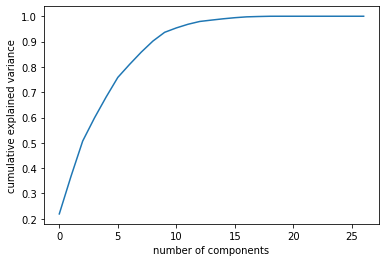

In [22]:
fossil_preproc.pca_feature_selection(base_data, eda=True)

In [23]:
principal_features = fossil_preproc.pca_feature_selection(base_data, 15)

#save features for inference
fossil_preproc.save_items(f'{OUTPUT_DIR}/principal_features.pkl', principal_features)

### Walk Forward Validation

- Only for evaluation, skip to training on full set otherwise

In [ ]:
from fossil.models import FossilEnsemble
from fossil.utils import fossil_mae

from fossil.config import ModelsConfig
from fossil.inference import make_predictions, prepare_test_context

ensembler = FossilEnsemble(fossil_mae)
primary_target_cols = [f'{target}_target_{i}' for target in primary_targets\
                           for i in range(ModelsConfig.N_STEPS)]

principal_features = fossil_preproc.load_saved_items(f'{OUTPUT_DIR}/principal_features.pkl')
cols = principal_features+['month','year']

non_features = ['sku_name','sku_coded']+primary_target_cols
test = pd.read_csv(f'{TEST_DIR}/Test.csv')

walk_forward_steps = len(dates)-ModelsConfig.N_STEPS-1

mae_dict = dict(
    month=[], 
    year=[], 
    blended_mae=[],
    Walk_forward_mae=[], 
    train_sku_count=[], 
    val_sku_count=[],
    new_sku = [])

y_true_cols = [f'sellin_target_{i}' for i in range(ModelsConfig.N_STEPS)]
for step in range(walk_forward_steps,0,-4):
    train_dates = dates[:-(ModelsConfig.N_STEPS+step)]
    val_dates = dates[-(ModelsConfig.N_STEPS+step):-step]
    
    if len(train_dates)<ModelsConfig.FOLDS:
        continue
        
    train_data = primary_data[primary_data[['month','year']].apply(tuple,axis=1).isin(train_dates)]
    val_context = primary_data[primary_data[['month','year']].apply(tuple,axis=1).isin([train_dates[-1]])]

    val = primary_data[primary_data[['month','year']].apply(tuple,axis=1).isin(val_dates)]
    val_context, _ = prepare_test_context(val_context, val, fossil_preproc)
    
    train_data = fossil_preproc.impute_missing(train_data, True, OUTPUT_DIR)
    val_context[y_true_cols] = val_context[y_true_cols].fillna(0)
    val_data = fossil_preproc.impute_missing(val_context, True, OUTPUT_DIR)
    
    mae_dict['train_sku_count'].append(train_data['sku_name'].nunique())
    mae_dict['val_sku_count'].append(val['sku_name'].nunique())
    
    val_data = val_data[val_data['sku_name'].isin(val['sku_name'].unique())]
    y_true = val_data[y_true_cols].values[:, -1]
    
    new_sku = set(val['sku_name'].unique()).difference(train_data['sku_name'].unique())
    feature_cols = [c for c in base_data.columns if c not in non_features and c in cols or c in primary_targets]

    oof_preds, cv_models, blended_mae, secondary_data = ensembler.blend_cv_models(principal_features,
                                                                                  primary_targets, 
                                                                                  train_data, 
                                                                                  fossil_preproc)
    sub_df = make_predictions(val, 
                              val_data, 
                              feature_cols,
                              primary_target_cols,
                              primary_targets,
                              cv_models)
    
    walk_forward_mae = fossil_mae(sub_df['Target'], y_true).mean()
    
    mae_dict['month'].append(val_dates[-1][0])
    mae_dict['year'].append(val_dates[-1][1])
    mae_dict['blended_mae'].append(blended_mae)
    mae_dict['Walk_forward_mae'].append(walk_forward_mae)
    mae_dict['new_sku'].append(len(new_sku))
    
    print("Walk forward MAE: ",walk_forward_mae)

In [ ]:
eval_df = pd.DataFrame(mae_dict)

In [ ]:
eval_df

In [ ]:
eval_df.Walk_forward_mae.mean()

In [ ]:

eval_df['date'] = eval_df['month'].astype(str)+'/'+eval_df['year'].astype(str)
# exp_train = exp_train.set_index(exp_train['date'])

eval_df.sort_values(['year','month']).set_index(eval_df['date']).drop(columns=['month','year']).plot(subplots=True, figsize=(15,8))

In [ ]:
eval_df.sort_values(['year','month']).set_index(eval_df['date'])[['blended_mae','Walk_forward_mae']].plot.bar(rot=45, figsize=(15,6))

### Training on full set

In [ ]:
from fossil.models import FossilEnsemble
from fossil.utils import fossil_mae

ensembler = FossilEnsemble(fossil_mae)

oof_preds, cv_models, blended_mae, secondary_data = ensembler.blend_cv_models(
    principal_features, 
    primary_targets, 
    base_data, 
    fossil_preproc)

Training lgb model for timestep 1 sellin forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[374]	training's l1: 110015	valid_1's l1: 156356


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 112022	valid_1's l1: 131156
Early stopping, best iteration is:
[515]	training's l1: 111519	valid_1's l1: 131035


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 108948	valid_1's l1: 133296
Early stopping, best iteration is:
[537]	training's l1: 107767	valid_1's l1: 132928
Elapsed 0.23 mins
--------------------------------------------------


Training lgb model for timestep 2 sellin forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 106323	valid_1's l1: 151511
Early stopping, best iteration is:
[569]	training's l1: 104404	valid_1's l1: 151035


Training fold 2
Training u

In [ ]:
ensembler.save_cv_models(cv_models, MODEL_CHECKPOINT_DIR)

## Inference

In [ ]:
import pandas as pd 
import numpy as np

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
context = pd.read_csv(f'{OUTPUT_DIR}/context.csv')

In [ ]:
from fossil.inference import prepare_test_context
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilPreprocessor, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(save_path=f'{OUTPUT_DIR}/sku_dict.pkl')


fossil_preproc = FossilPreprocessor(sku_encoder)
test_context, test_dates = prepare_test_context(context, test, fossil_preproc)

In [ ]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

dates = fossil_preproc.sort_dates(test_context)
test_data = fossil_preproc.prepare_primary_data(test_context, dates, primary_targets)

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_data = fossil_preproc.impute_missing(test_context, True, OUTPUT_DIR)

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [ ]:
primary_target_cols = [f'{target}_target_{i}' for target in primary_targets\
                           for i in range(ModelsConfig.N_STEPS)]
# pred_cols = [f'{target}_preds_{i}' for target in primary_targets for i in range(ModelsConfig.N_STEPS)]

principal_features = fossil_preproc.load_saved_items(f'{OUTPUT_DIR}/principal_features.pkl')
cols = principal_features+['month','year']

non_features = ['sku_name','sku_coded']+primary_target_cols
feature_cols = [c for c in test_data.columns if c not in non_features and c in cols or c in primary_targets]

In [ ]:
# from fossil.models.gbdt import FossilGBDT
# gbdt_models = FossilGBDT()

# cv_models = 

In [ ]:
from fossil.inference import make_predictions

sub_df = make_predictions(test, test_data, feature_cols, primary_target_cols, primary_targets, cv_models)

In [ ]:
save_name = f'{OUTPUT_DIR}/fossil_blended_{blended_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [ ]:
sub_df.sort_values(['sku_name','year','month'])#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,price_6month_MM,price_9month_MM,sku_coded,time_step,sellin_preds,sellout_preds,onhand_inventory_preds,leftover_inventory_preds,Target,Item_ID
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,149.0,149.0,74.0,3,57211.102826,38722.219865,3.052770e+05,11015.497755,30208.060644,ABEAHAMASHL_2_2022
7,ABEENNEARMAZZ,2,2022,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,129.0,129.0,633.0,3,83927.580510,61319.886857,4.002875e+05,26995.468336,33526.370690,ABEENNEARMAZZ_2_2022
11,ABEETTEABE,2,2022,3352017.0,1211548.0,1095053.0,61793.0,0.0,0.0,0.0,...,159.0,159.0,789.0,3,692378.921280,333928.987358,2.570089e+06,355217.421451,232400.420308,ABEETTEABE_2_2022
15,ABERTHAKEVAZZ,2,2022,2366368.0,749620.0,729360.0,15195.0,0.0,0.0,0.0,...,135.0,135.0,3640.0,3,108969.521701,53195.960093,4.329868e+05,31178.171753,41417.213242,ABERTHAKEVAZZ_2_2022
19,ABEWARDREYZZ,2,2022,153976.0,47611.0,31403.0,0.0,0.0,0.0,0.0,...,135.0,135.0,3241.0,3,54917.128203,36807.329643,3.030801e+05,13273.859015,21507.052183,ABEWARDREYZZ_2_2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,WHITSHIAALBEZZ,2,2022,888401.0,52676.0,13169.0,0.0,0.0,0.0,0.0,...,169.0,169.0,1422.0,3,72355.348099,49503.806127,5.914422e+05,39491.504193,38238.252325,WHITSHIAALBEZZ_2_2022
1483,YOSHILSEHOWAZZ,2,2022,246159.0,6078.0,0.0,0.0,0.0,0.0,0.0,...,135.0,135.0,3586.0,3,34864.825357,19984.092221,1.016861e+05,5159.798757,16163.684773,YOSHILSEHOWAZZ_2_2022
1487,YOSHLEENBART,2,2022,1664359.0,111430.0,67871.0,31403.0,0.0,0.0,0.0,...,129.0,129.0,725.0,3,180769.215716,72820.112756,4.536020e+05,83495.894853,77845.470380,YOSHLEENBART_2_2022
1491,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,129.0,129.0,248.0,3,271136.565019,84891.764804,8.056050e+05,156106.160024,92614.626729,YOSHRENECARL_2_2022


In [ ]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,35072.725079,0,47640.930020,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,44672.654183,1,77943.376682,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,43210.416403,2,87058.224649,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,56187.085045,3,79939.259651,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,159290.384286,0,203265.296056,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,207297.427046,3,223475.074890,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,205218.138990,0,220793.851680,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,196515.846253,1,223099.976004,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,140360.727007,2,189837.577327,YOSHTLYNYOSHZZ_1_2022
